# < Deep Learning - PART1 TF2 Basics >
# Ch 4. Workshop : FCDNs - MNIST for Digit Recognition
2021/10/01

**[ Reference ] :**
> 1. FRANÇOIS CHOLLET, **Deep Learning with Python**, Chapter 3, Section 5, Manning, 2018. 
  (https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf)
  
> 2. TensorBoard - Guide : **Displaying image data in TensorBoard**, https://www.tensorflow.org/tensorboard/image_summaries

----

In [1]:
import tensorflow as tf
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import io
import itertools
import sklearn
from sklearn.metrics import confusion_matrix

tf.__version__

'2.6.0'

### Using Fully-Connected Deep Networks (FCDNs) to classify hand-written digits :

+ In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of **`MNIST`** images. We do this via passing the argument `input_shape=(28, 28, 1)` to our first hidden layer.
+ The FCDN model consists of 2 hidden layers: the first hidden layer poccesses 128 hidden units, while the second one has 64 hidden units. 
+ There are 10 classes within the output layer.

In [2]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter 
2.

In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape the datasets into 4D-Tensor format...
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

#### [ About **Loss Function** ]:  `categorical_crossentropy` vs. `sparse_categorical_crossentropy`
> + If the targets are **one-hot encoded**, use **`categorical_crossentropy`**.
        - Examples of one-hot encodings:
                [1,0,0]
                [0,1,0]
                [0,0,1]
+ But if the targets are **integers**, use **`sparse_categorical_crossentropy`**.
        - Examples of integer encodings (for the sake of completion):
                    1
                    2
                    3

## Backpropagation

In [5]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Output Data for TensorBoard



+ #### Creating a File Directory for TensorBoard

In [6]:
# File-directory Path for TensorBoard 
log_dir="logs/fit/fcdn/" + datetime.now().strftime("%Y%m%d-%H%M%S")

+ #### Output MNIST Images for TensorBoard

In [7]:
# tf.summary.create_file_writer() : 
#   Creates a summary file writer for the given log directory.
log_images = log_dir + "/images"
file_writer = tf.summary.create_file_writer(log_images)

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' 
       to a PNG image and returns it. The supplied figure 
       is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed 
    # directly inside the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def image_grid():
    """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(10,10))
    for i in range(25):
        # Start next subplot.
        plt.subplot(5, 5, i + 1, title=class_names[train_labels[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i], cmap=plt.cm.binary)
    return figure

def log_image_plots(epoch, logs):
    # Prepare the plot
    figure = image_grid()
    # Convert to image and log
    with file_writer.as_default():
        tf.summary.image("Training data", plot_to_image(figure), step=0)

+ #### Output Confusion Matrix for TensorBoard

In [8]:
def plot_confusion_matrix(cm, class_names):
    """ 
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 
                       decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [9]:
# tf.summary.create_file_writer() : 
#   Creates a summary file writer for the given log directory.
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

# Class names for MNIST digit images: 0 ~ 9
class_names = [str(i) for i in range(10)]

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

+ #### Callback methods

In [10]:
# Define the Keras TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# Define the per-epoch callbacks for MNIST images.
image_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_image_plots)

# Define the per-epoch callbacks for confusion matrix.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [11]:
# validation_split: Float between 0 and 1. 
#                   Fraction of the training data to be used as validation data.

history = model.fit(train_images, 
                    train_labels, 
                    epochs=15, 
                    batch_size=512,
                    validation_split=0.1,
                    callbacks=[tensorboard_callback, 
                               image_callback,
                               cm_callback])

Epoch 1/15
106/106 [==============================] - 2s 12ms/step - loss: 0.8763 - accuracy: 0.7545 - val_loss: 0.2480 - val_accuracy: 0.9265
Epoch 2/15
106/106 [==============================] - 0s 4ms/step - loss: 0.2547 - accuracy: 0.9260 - val_loss: 0.1697 - val_accuracy: 0.9512
Epoch 3/15
106/106 [==============================] - 0s 4ms/step - loss: 0.1849 - accuracy: 0.9457 - val_loss: 0.1317 - val_accuracy: 0.9630
Epoch 4/15
106/106 [==============================] - 0s 4ms/step - loss: 0.1440 - accuracy: 0.9573 - val_loss: 0.1181 - val_accuracy: 0.9632
Epoch 5/15
106/106 [==============================] - 0s 4ms/step - loss: 0.1132 - accuracy: 0.9666 - val_loss: 0.0964 - val_accuracy: 0.9710
Epoch 6/15
106/106 [==============================] - 0s 4ms/step - loss: 0.0941 - accuracy: 0.9723 - val_loss: 0.1071 - val_accuracy: 0.9695
Epoch 7/15
106/106 [==============================] - 0s 4ms/step - loss: 0.0784 - accuracy: 0.9765 - val_loss: 0.0972 - val_accuracy: 0.9715
Epoch

Let's evaluate the model on the test data:

In [12]:
# verbose: 0 or 1. Verbosity mode. 0 = silent, 1 = progress bar
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

In [13]:
test_acc

0.9771999716758728

In [14]:
test_loss

0.07573146373033524

## Plotting results

> + **The call to `model.fit()` returns a `History` object.** 
>
>
> + **This object has a member `history`, which is a dictionary containing data about everything that happened during training.**
 
Let's take a look at it:

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

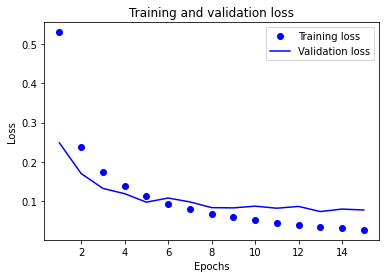

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']          
val_acc = history.history['val_accuracy']  
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

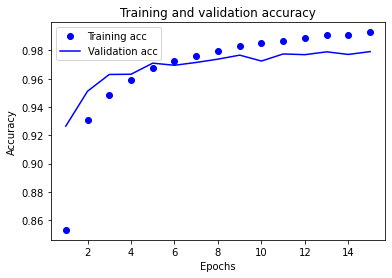

In [17]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']          
val_acc_values = history_dict['val_accuracy']  

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Prediction

In [18]:
test_predict = model.predict(test_images)
test_predict

array([[1.5047672e-07, 1.2711048e-09, 3.3050892e-05, ..., 9.9935359e-01,
        1.1711770e-06, 2.3033490e-05],
       [4.6101580e-09, 1.4413783e-05, 9.9997699e-01, ..., 5.3525377e-14,
        2.5796912e-06, 7.9698786e-13],
       [8.3861751e-06, 9.9881315e-01, 4.3890518e-04, ..., 3.5490209e-04,
        1.8984842e-04, 1.4843447e-06],
       ...,
       [1.4883571e-13, 1.1322564e-13, 1.0123786e-13, ..., 3.1463259e-08,
        3.3519623e-08, 7.8649146e-07],
       [6.2846061e-12, 2.0362026e-13, 2.0849162e-12, ..., 8.5118544e-11,
        2.1644304e-05, 1.7771976e-12],
       [3.4703443e-10, 3.5609900e-15, 9.8466929e-12, ..., 1.9046985e-18,
        2.1573755e-11, 6.8828145e-11]], dtype=float32)

In [19]:
import numpy as np
test_predict_result = np.array([np.argmax(test_predict[i]) for i in range(len(test_predict))])
test_predict_result

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [20]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

## Confusion Matrix

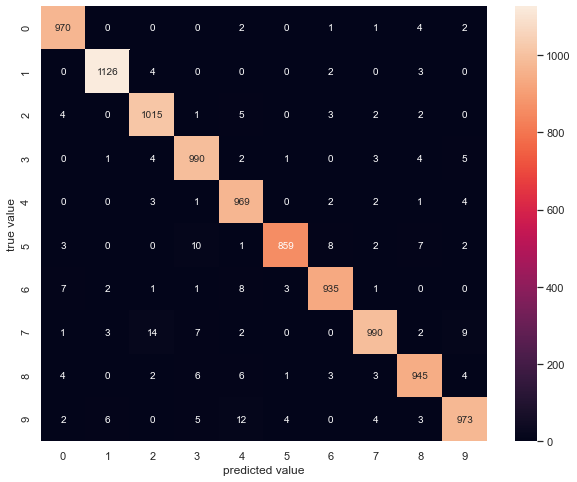

array([[ 970,    0,    0,    0,    2,    0,    1,    1,    4,    2],
       [   0, 1126,    4,    0,    0,    0,    2,    0,    3,    0],
       [   4,    0, 1015,    1,    5,    0,    3,    2,    2,    0],
       [   0,    1,    4,  990,    2,    1,    0,    3,    4,    5],
       [   0,    0,    3,    1,  969,    0,    2,    2,    1,    4],
       [   3,    0,    0,   10,    1,  859,    8,    2,    7,    2],
       [   7,    2,    1,    1,    8,    3,  935,    1,    0,    0],
       [   1,    3,   14,    7,    2,    0,    0,  990,    2,    9],
       [   4,    0,    2,    6,    6,    1,    3,    3,  945,    4],
       [   2,    6,    0,    5,   12,    4,    0,    4,    3,  973]],
      dtype=int64)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test_labels, test_predict_result)

plt.figure(figsize=(10,8))
sns.heatmap(mat, square=False, annot=True, fmt ='d', cbar=True)
plt.xlim((0, 10))
plt.ylim((10, 0))
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

mat

## TensorBoard
-----------------

> ###  To run TensorBoard, run the following command on `Anaconda Prompt` :
`tensorboard --logdir=`_path/to/log-directory_

> + For instance, **`tensorboard --logdir logs/fit/fcdn`**

> Connecting to **`http://localhost:6006`**

-----------------